In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Fixed properties of the tracker system
ch0_freq = 160.120e6 # Hz
channel_spacing = 10000 # Hz
num_channels = 100
valid_pulse_rates = [30, 48, 80]
beep_duration = 0.0185 # seconds

# Configurable test signal properties
beeps = dict()
beep_powers = dict()
beeps[15] = [80]*10 # 10 beeps at 80 BPM on channel 15
beep_powers[15] = -10

beeps[41] = [48]*5
beep_powers[41] = -15

sampling_rate = 1_024_000  # Hz

In [84]:
signal = np.zeros(0, dtype=np.complex64)

for channel_num in beeps.keys():
    print(f'Adding beeps to channel {channel_num}')
    print(f'  Beeps: {beeps[channel_num]}')

    # Start with a random delay for each channel of up to 1 second
    ch_signal = np.zeros(np.random.randint(sampling_rate), dtype=np.complex64)

    tone_freq = (channel_num - num_channels/2)  * channel_spacing # ch0_freq + 
    beep_power_linear = 10 ** (beep_powers[channel_num] / 10.0)

    # Generate the samples for single beep
    t = np.linspace(0, beep_duration, np.round(beep_duration * sampling_rate).astype(int), endpoint=False, dtype=np.complex64)
    beep_signal = beep_power_linear * np.exp(2j * np.pi * tone_freq * t)
    n_samps_beep = len(beep_signal)

    for beep in beeps[channel_num]:
        ch_signal = np.append(ch_signal, beep_signal)
        n_samps_beep_period = np.round(60 / beep * sampling_rate).astype(int)
        ch_signal = np.append(ch_signal, [0]*(n_samps_beep_period - n_samps_beep))

    signal.resize(np.max([len(ch_signal), len(signal)]))
    signal[:len(ch_signal)] += ch_signal

len(signal)

Adding beeps to channel 15
  Beeps: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Adding beeps to channel 41
  Beeps: [48, 48, 48, 48, 48]


8094837

In [85]:
noise_power = np.sqrt(10 ** (-40 / 10))

noiseReal = np.random.normal(0, np.sqrt(2)/2, len(signal))
noiseImag = np.random.normal(0, np.sqrt(2)/2, len(signal))
noise = noise_power * (noiseReal + 1j*noiseImag)

noisySignal = signal + noise

In [72]:
np.save("test_signal", noisySignal.astype(np.complex128))

iq_fc32 = noisySignal.astype(np.complex64)

with open(f'test_signal.fc32', 'wb') as f:
    f.write(iq_fc32.tobytes())

Text(0, 0.5, 'Amplitude')

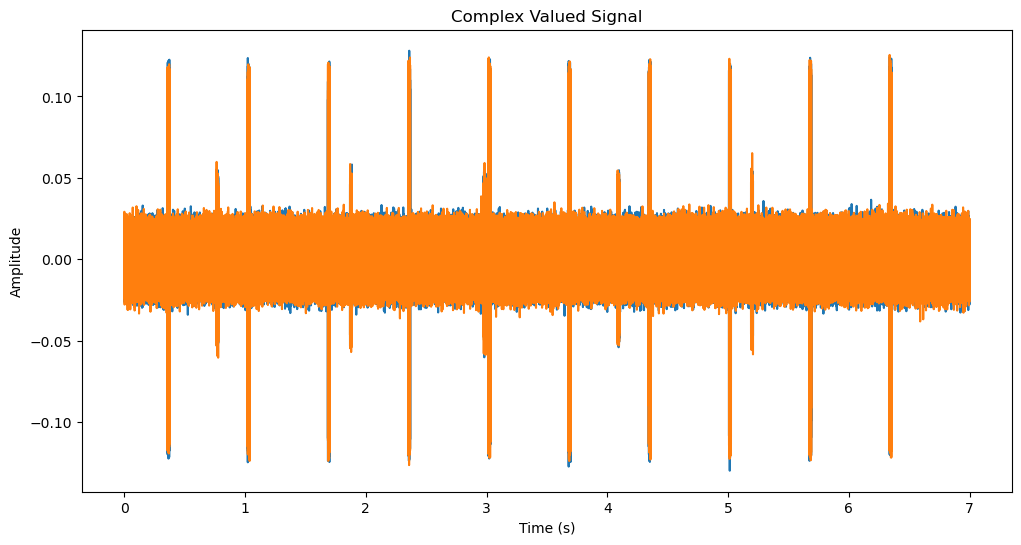

In [86]:
# Plot the time domain signal
plt.figure(figsize=(12, 6))

t = np.linspace(0, int(len(noisySignal)/sampling_rate), len(signal), endpoint=False).astype(np.float32)

plt.plot(t, noisySignal.real, label='Real')
plt.plot(t, noisySignal.imag, label='Imaginary')

plt.title('Complex Valued Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


Text(0.5, 1.0, 'Power Spectral Density')

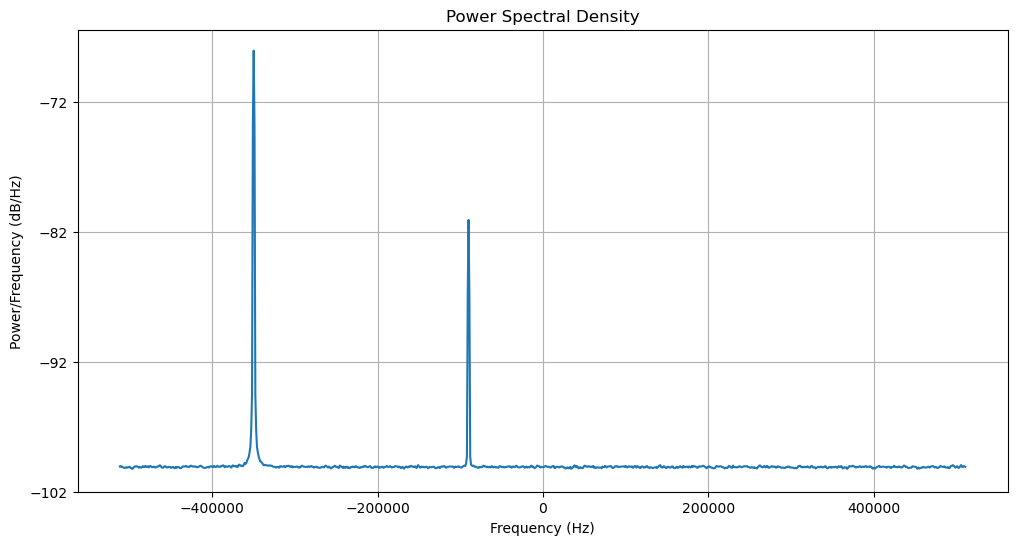

In [87]:
# Plot the spectrum in dBFS
plt.figure(figsize=(12, 6))

plt.psd(noisySignal, NFFT=1024, Fs=sampling_rate)

# Highlight the frequency range between low and high frequencies
#plt.axvspan(low_frequency, high_frequency, color='gray', alpha=0.3, label=f'{low_frequency}-{high_frequency} Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density')
